# Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
from dask.distributed import Client

ImportError: dask.distributed is not installed.

Please either conda or pip install distributed:

  conda install dask distributed             # either conda install
  python -m pip install "dask[distributed]" --upgrade    # or pip install

# Parameters

In [2]:
date_start = datetime.date(2022,1,1)
duration = 180

# path of gridded rainfall datasets
TAMSAT_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/TAMSAT_v3.1_burkina_rfe_filled"
# CHIRPS_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/CHIRPS_v2.0_Africa_burkina"

# path for gridded weather datasets
AgERA5_data_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/AgERA5_burkina/"

# parameter file names
file_paramVariete = "USA_iowa_V42.yaml"
file_paramITK = "USA_iowa_V42.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# comparison with existing results : data exported from SARRA-H
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

# Loading data

In [3]:
grid_width, grid_height = get_grid_size(TAMSAT_path, date_start, duration)

data = xr.Dataset()
data = load_TAMSAT_data(data, TAMSAT_path, date_start, duration)
data = load_AgERA5_data(data, AgERA5_data_path, date_start, duration)
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)
data = initialize_default_irrigation(data)
data = load_iSDA_soil_data(data, grid_width, grid_height)

100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


In [4]:
data

<xarray.Dataset>
Dimensions:        (x: 239, y: 186, time: 180)
Coordinates:
  * x              (x) float64 -5.963 -5.925 -5.888 -5.85 ... 2.887 2.925 2.962
  * y              (y) float64 15.97 15.94 15.9 15.86 ... 9.15 9.113 9.075 9.038
    spatial_ref    int64 0
Dimensions without coordinates: time
Data variables: (12/13)
    rain           (time, y, x) float32 0.0 0.0 1.6 1.7 1.5 ... 8.6 8.1 6.8 6.2
    tpMoy          (time, y, x) float32 nan nan nan nan ... 24.54 24.54 24.23
    ET0            (time, y, x) float32 nan nan nan nan ... 2.47 2.47 2.47 2.35
    rg             (time, y, x) float32 nan nan nan nan ... 20.4 20.4 20.4 19.83
    irrigation     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    soil_type      (y, x) float64 11.0 11.0 9.0 9.0 11.0 ... 9.0 9.0 9.0 9.0 9.0
    ...             ...
    epaisseurSurf  (y, x) float64 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0
    stockIniProf   (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stockIniSurf   (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    seuilRuiss     (y, x) float64 20.0 20.0 18.0 18.0 ... 18.0 18.0 18.0 18.0
    pourcRuiss     (y, x) float64 0.27 0.27 0.32 0.32 ... 0.32 0.32 0.32 0.32
    ru             (y, x) float64 130.0 130.0 155.0 155.0 ... 155.0 155.0 155.0

# Run

In [5]:
import warnings
warnings.filterwarnings("ignore")

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration)
data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, paramTypeSol, paramITK)
data = EvalPar(data)

# setting up a dataset with sowing date in julian format
data["sowing_date"] = (data["rain"].dims, np.full((duration, grid_width, grid_height), (paramITK["DateSemis"] - date_start).days))


for j in tqdm(range(duration)):

    # calculating daily thermal time, independently of sowing date
    data = calculate_daily_thermal_time(j, data, paramVariete)

    data = testing_for_initialization(j, data, paramITK, paramVariete)
    data = testing_for_phase_1(j, data, paramITK, paramVariete)
    data = testing_for_phase_2(j, data, paramITK, paramVariete)
    data = testing_for_phase_3(j, data, paramITK, paramVariete)
    data = testing_for_phase_4(j, data, paramITK, paramVariete)
    data = testing_for_phase_5(j, data, paramITK, paramVariete)
    data = testing_for_phase_6(j, data, paramITK, paramVariete)

    # sum of thermal sime is being computed from the day the crop is sown, including the day of sowing
    data = calculate_sum_of_thermal_time(j, data, paramVariete)

    # water balance
    # evalIrrigPhase sp&cifique de l'irrigation automatique, on peut presque le conditionner au irrigAuto==True
    data = EvalIrrigPhase(j, data, paramITK)
    # sums rainfall and irrigation history
    data = PluieIrrig(j, data)
    # can be conditioned to the presence of mulch
    data = RempliMc(j, data, paramITK)
    data = EvalRunOff(j, data, paramTypeSol)
    data = EvolRurCstr2(j, data, paramITK) 
    
    # computation of filling of the tanks is done after other computations related to water,
    # as we consider filling is taken into consideration at the end of the day
    data = rempliRes(j, data) 

    # transpiration
    # estimation of the fraction of evaporable soil water (fesw)
    data = estimate_fesw(j, data) 
    data = estimate_kce(j, data, paramITK)
    data = estimate_soil_potential_evaporation(j, data)
    data = estimate_soil_evaporation(j, data)
    data = estimate_FEMcW_and_update_mulch_water_stock(j, data, paramITK)
    data = estimate_ftsw(j, data)
    data = estimate_kcp(j, data, paramVariete)
    data = estimate_potential_plant_transpiration(j, data)
    data = estimate_kcTot(j, data)
    data = estimate_pFact(j, data, paramVariete)
    data = estimate_cstr(j, data)
    data = estimate_plant_transpiration(j, data)
    
    # water consumption
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    
    # # phenologie
    data = update_root_growth_speed(j, data, paramVariete) 

    # # bilan carbone
    data = estimate_ltr(j, data, paramVariete)
    data = estimate_KAssim(j, data, paramVariete)
    data = estimate_conv(j,data,paramVariete)

    # data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    
    data = update_assimPot(j, data, paramVariete, paramITK)
    data = update_assim(j, data)

    data = estimate_maintainance_respiration(j, data, paramVariete)
    data = update_total_biomass(j, data, paramVariete, paramITK)


    data = update_total_biomass_stade_ip(j, data)
    data = update_total_biomass_at_flowering_stage(j, data)
    data = update_potential_yield(j, data, paramVariete)
    data = update_potential_yield_delta(j, data, paramVariete)

    data = update_aboveground_biomass(j, data, paramVariete)

    data = estimate_reallocation(j, data, paramVariete)

    data = update_root_biomass(j, data)
    data = update_vegetative_biomass(j, data)
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    # data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


100%|██████████| 180/180 [02:07<00:00,  1.41it/s]


In [6]:
data

<xarray.Dataset>
Dimensions:                             (x: 239, y: 186, time: 180)
Coordinates:
  * x                                   (x) float64 -5.963 -5.925 ... 2.962
  * y                                   (y) float64 15.97 15.94 ... 9.075 9.038
    spatial_ref                         int64 0
Dimensions without coordinates: time
Data variables: (12/116)
    rain                                (time, y, x) float32 0.0 0.0 ... 6.8 6.2
    tpMoy                               (time, y, x) float32 nan nan ... 24.23
    ET0                                 (time, y, x) float32 nan nan ... 2.35
    rg                                  (time, y, x) float32 nan nan ... 19.83
    irrigation                          (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    soil_type                           (y, x) float64 11.0 11.0 9.0 ... 9.0 9.0
    ...                                  ...
    trSurf                              (time, y, x) float64 0.0 0.0 ... 31.0
    UBTCulture                          (time, y, x) float64 0.0 0.0 ... 0.0 0.0
    vRac                                (time, y, x) float64 0.0 0.0 ... 30.0
    irrigAuto                           (time, y, x) bool False False ... False
    par                                 (time, y, x) float32 nan nan ... 9.917
    sowing_date                         (time, y, x) int64 31 31 31 ... 31 31 31

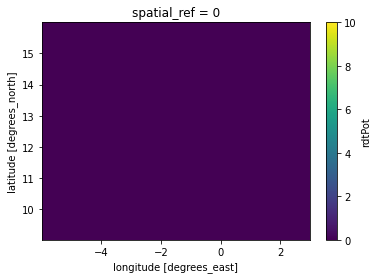

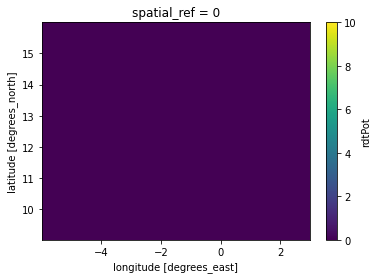

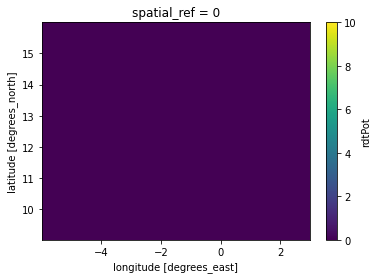

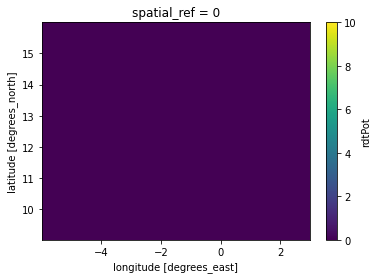

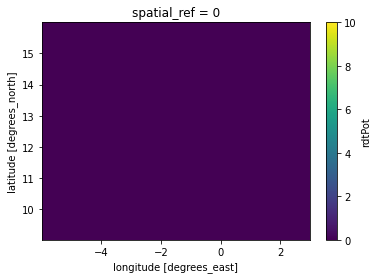

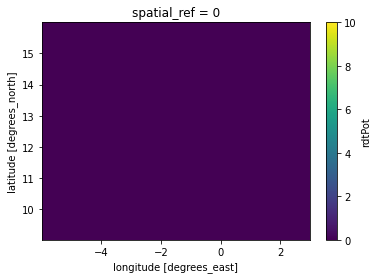

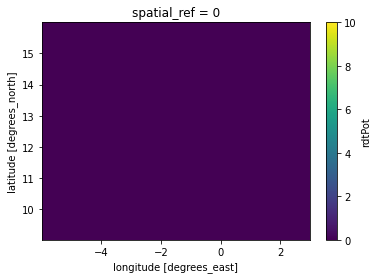

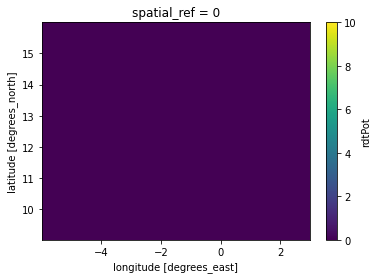

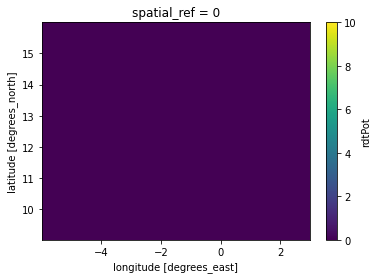

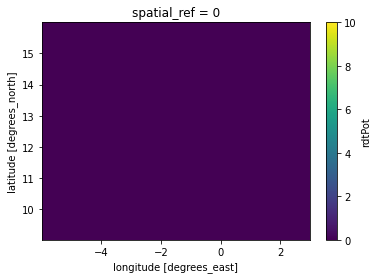

In [7]:
for i in range(10):
    data["rdtPot"][18*i,:,:].plot(vmin=0, vmax=10)
    plt.show()

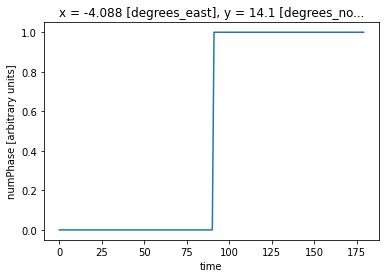

In [8]:
data["numPhase"][:,50,50].plot()

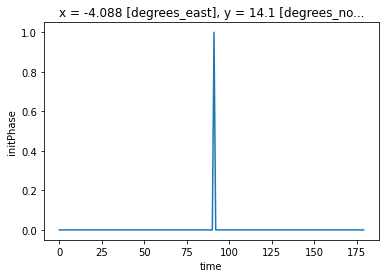

In [9]:
data["initPhase"][:,50,50].plot()

In [10]:
(data["ru"] * data["profRu"] / 1000)

<xarray.DataArray (y: 186, x: 239)>
array([[234., 234., 279., ..., 279., 324., 279.],
       [279., 279., 279., ..., 324., 279., 279.],
       [279., 279., 279., ..., 279., 279., 279.],
       ...,
       [324., 324., 324., ..., 279., 279., 279.],
       [324., 324., 324., ..., 279., 279., 279.],
       [324., 324., 324., ..., 279., 279., 279.]])
Coordinates:
  * x            (x) float64 -5.963 -5.925 -5.888 -5.85 ... 2.887 2.925 2.962
  * y            (y) float64 15.97 15.94 15.9 15.86 ... 9.15 9.113 9.075 9.038
    spatial_ref  int64 0

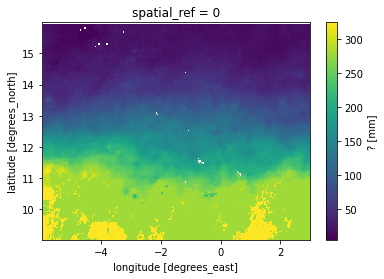

In [11]:
data["total_tank_stock"][170,:,:].plot()

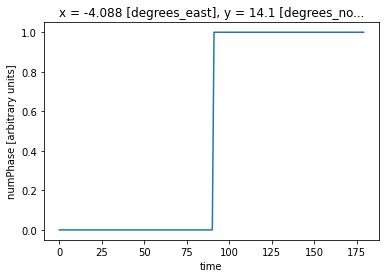

In [12]:
data["numPhase"][:,50,50].plot()

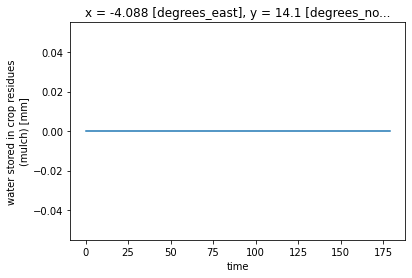

In [13]:

data["mulch_water_stock"][:,50,50].plot()

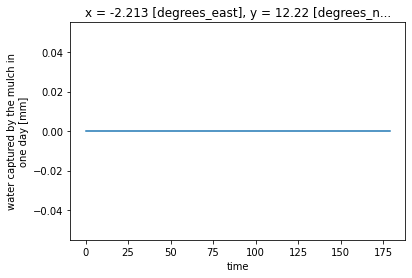

In [14]:
data["water_gathered_by_mulch"][:,100,100].plot()

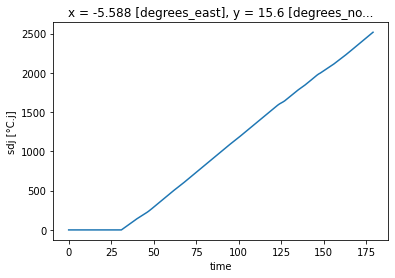

In [15]:
data["sdj"][:,10,10].plot()

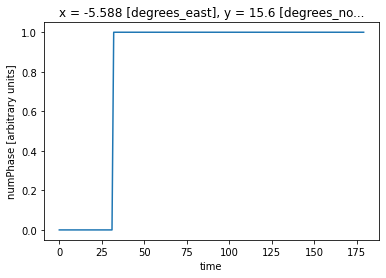

In [16]:
data["numPhase"][:,10,10].plot()